In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.feature_extraction.text import CountVectorizer

import spacy
# import en_core_web_trf

from scipy.stats.mstats import winsorize
from scipy import stats

# Loading in Data

In [7]:
# nlp = spacy.load("en_core_web_sm")
nlp = spacy.load("en_core_web_lg")
# nlp = spacy.load("en_core_web_trf")

spacy.prefer_gpu()

True

In [8]:
dear_ceo_folder = '.\data\dear_ceo'
year_dict = {}
for filename in os.listdir(dear_ceo_folder):
    if filename.endswith(".txt"):
        year = filename.split('_')[-1][0:-4]
        year_dict[year] = os.path.join(dear_ceo_folder, filename)

print(year_dict)

{'2012': '.\\data\\dear_ceo\\dear_ceo_2012.txt', '2013': '.\\data\\dear_ceo\\dear_ceo_2013.txt', '2014': '.\\data\\dear_ceo\\dear_ceo_2014.txt', '2015': '.\\data\\dear_ceo\\dear_ceo_2015.txt', '2016': '.\\data\\dear_ceo\\dear_ceo_2016.txt', '2017': '.\\data\\dear_ceo\\dear_ceo_2017.txt', '2018': '.\\data\\dear_ceo\\dear_ceo_2018.txt', '2019': '.\\data\\dear_ceo\\dear_ceo_2019.txt', '2020': '.\\data\\dear_ceo\\dear_ceo_2020.txt', '2021': '.\\data\\dear_ceo\\dear_ceo_2021.txt', '2022': '.\\data\\dear_ceo\\dear_ceo_2022.txt'}


In [9]:
nlp.max_length = 2000000

In [10]:
def process_text(text):
    doc = nlp(text.lower())
    result = []
    for token in doc:
        if token.text in nlp.Defaults.stop_words:
            continue
        if token.is_punct:
            continue
        if token.lemma_ == '-PRON-':
            continue
        result.append(token.lemma_)
    return " ".join(result)

In [30]:
def generate_table(year):
    dear_ceo = year_dict[year]
    if os.path.isfile(dear_ceo):
        text = open(dear_ceo, "r", encoding="utf8").read()
        dear_ceo_text = process_text(text)
        dear_ceo_text = nlp(dear_ceo_text)
        # dear_ceo_text = nlp(text)


    base = '.\data'
    sub_folders = os.listdir(base)
    for folder in sub_folders:
        if year in folder:
            folder_8k = os.path.join(base, folder)


    rows_list = []
    skipped = []


    for filename in os.listdir(folder_8k):
        f1 = os.path.join(folder_8k, filename)

        for f2 in os.listdir(f1):
            f3 = os.path.join(f1, f2)
            if f3.endswith(".txt"):
                dict1 = {}
                data = f3.split('\\')[-1].split('_')
                dict1['company'] = data[0]
                dict1['doc_id'] = data[1]
                dict1['date'] = data[3]

                text = open(f3, "r", encoding="utf8").read()

                
                if len(text) > 2000000:
                    skipped.append(f3)
                    continue

                text_8k = process_text(text)
                text_8k = nlp(text_8k)

                dict1['similarity'] = dear_ceo_text.similarity(text_8k)

                rows_list.append(dict1)

    df = pd.DataFrame(rows_list)
    return df,skipped




In [35]:
years = [2015, 2016 , 2017, 2018, 2019, 2020, 2021, 2022]
# master_df = pd.DataFrame()
all_skipped = []


for year in years:
    df,skipped = generate_table(str(year))
    all_skipped.append(skipped)
    # master_df = pd.concat([master_df, df], ignore_index=True)
    print('Done with year: ', year)
    df.to_pickle("./master_df" + str(year) + ".pkl")  



Done with year:  2016


C:\Users\aaron\AppData\Local\Temp\ipykernel_19160\3633480748.py:43: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  dict1['similarity'] = dear_ceo_text.similarity(text_8k)


Done with year:  2017
Done with year:  2018
Done with year:  2019
Done with year:  2020
Done with year:  2021
Done with year:  2022


In [209]:
master_df = pd.read_pickle("./master_df.pkl")  
master_df.to_pickle("./master_df" + str(2015) + ".pkl")  
master_df

,company,doc_id,date,similarity
0,AAL,0000004515,20190110,0.833389
1,AAL,0000004515,20190124,0.838403
2,AAL,0000004515,20190110,0.933081
3,AAL,0000004515,20190124,0.808383
4,AAL,0000006201,20190212,0.874720
...,...,...,...,...
16433,XRAY,0000818479,20220228,0.791388
16434,XRAY,0000818479,20220222,0.913839
16435,XRAY,0000818479,20220228,0.836279
16436,ZION,0000109380,20220124,0.775720


# Preprocessing

In [40]:
years = [2015, 2016 , 2017, 2018, 2019, 2020, 2021, 2022]
df = pd.DataFrame()

for year in years:
    temp_df = pd.read_pickle("./master_df" + str(year) + ".pkl")
    df = pd.concat([df, temp_df], ignore_index=True)

In [3]:
df.to_pickle("./master_df.pkl")  
df = pd.read_pickle("./master_df.pkl")  
df

,company,doc_id,date,similarity,rescaled_similarity,year,lagged_similarity,rescaled_similarity_lagged,rescaled_similarity_lagged,rescaled_similarity_lagged
0,AAL,0000004515,2019-01-10,0.833389,-0.032357,2019,NaN,0.123699,0.399284,0.399284
1,AAL,0000004515,2019-01-24,0.838403,-0.012299,2019,-0.032357,0.123699,0.399284,0.399284
2,AAL,0000004515,2019-01-10,0.933081,0.366411,2019,-0.012299,0.123699,0.399284,0.399284
3,AAL,0000004515,2019-01-24,0.808383,-0.132380,2019,0.366411,0.123699,0.399284,0.399284
4,AAL,0000006201,2019-02-12,0.874720,0.132966,2019,-0.132380,0.123699,0.399284,0.399284
...,...,...,...,...,...,...,...,...,...,...
16433,XRAY,0000818479,2022-02-28,0.791388,-0.200360,2022,-0.172850,0.526646,0.491459,0.491459
16434,XRAY,0000818479,2022-02-22,0.913839,0.289442,2022,-0.200360,0.526646,0.491459,0.491459
16435,XRAY,0000818479,2022-02-28,0.836279,-0.020795,2022,0.289442,0.526646,0.491459,0.491459
16436,ZION,0000109380,2022-01-24,0.775720,-0.263032,2022,-0.331908,-0.211220,0.343987,0.343987


In [21]:
num_disclosures = df.groupby(['year', 'company']).count().reset_index()
num_disclosures['num_disc'] = num_disclosures['doc_id']
num_disclosures = num_disclosures[['year','company','num_disc']]

In [4]:
mean = np.mean(df['similarity'])
data = (df['similarity'] - mean)
data = data[data > -0.2]*4
df['rescaled_similarity'] = data

In [5]:
mean

0.8414781211799066

Text(0.5, 1.0, 'Similarity Distribution')

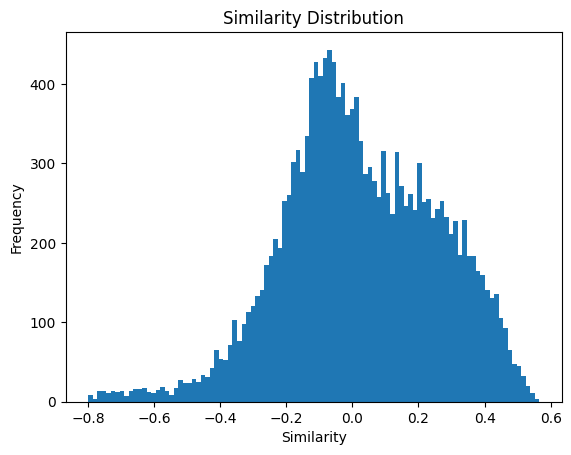

In [138]:
plt.hist(data, bins=100)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Similarity Distribution')

In [142]:
print(df['rescaled_similarity'].describe().to_latex())

\begin{tabular}{lr}
\toprule
 & rescaled_similarity \\
\midrule
count & 16200.000000 \\
mean & 0.022323 \\
std & 0.234423 \\
min & -0.799013 \\
25% & -0.129887 \\
50% & 0.006328 \\
75% & 0.200753 \\
max & 0.564856 \\
\bottomrule
\end{tabular}



In [122]:
print(df[df.similarity == df.similarity.min()])

      company      doc_id      date  similarity
11663       T  0000732717  20200129   -0.021848


In [128]:
df.groupby('company').count().mean()

doc_id        32.810379
date          32.810379
similarity    32.810379
dtype: float64

In [127]:
len(pd.unique(df['company']))


501

In [11]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df

,company,doc_id,date,similarity,rescaled_similarity,year,lagged_similarity,rescaled_similarity_lagged,rescaled_similarity_lagged,rescaled_similarity_lagged
0,AAL,0000004515,2019-01-10,0.833389,-0.032357,2019,NaN,0.123699,0.399284,0.399284
1,AAL,0000004515,2019-01-24,0.838403,-0.012299,2019,-0.032357,0.123699,0.399284,0.399284
2,AAL,0000004515,2019-01-10,0.933081,0.366411,2019,-0.012299,0.123699,0.399284,0.399284
3,AAL,0000004515,2019-01-24,0.808383,-0.132380,2019,0.366411,0.123699,0.399284,0.399284
4,AAL,0000006201,2019-02-12,0.874720,0.132966,2019,-0.132380,0.123699,0.399284,0.399284
...,...,...,...,...,...,...,...,...,...,...
16433,XRAY,0000818479,2022-02-28,0.791388,-0.200360,2022,-0.172850,0.526646,0.491459,0.491459
16434,XRAY,0000818479,2022-02-22,0.913839,0.289442,2022,-0.200360,0.526646,0.491459,0.491459
16435,XRAY,0000818479,2022-02-28,0.836279,-0.020795,2022,0.289442,0.526646,0.491459,0.491459
16436,ZION,0000109380,2022-01-24,0.775720,-0.263032,2022,-0.331908,-0.211220,0.343987,0.343987


In [12]:
df = df.drop(columns=['lagged_similarity', 'rescaled_similarity_lagged'])
lagged_sim = df.groupby(['company','year']).max().shift(-1)['rescaled_similarity']
df = df.join(lagged_sim, on=['company','year'], rsuffix='_lagged')
df

,company,doc_id,date,similarity,rescaled_similarity,year,rescaled_similarity_lagged
0,AAL,0000004515,2019-01-10,0.833389,-0.032357,2019,0.399284
1,AAL,0000004515,2019-01-24,0.838403,-0.012299,2019,0.399284
2,AAL,0000004515,2019-01-10,0.933081,0.366411,2019,0.399284
3,AAL,0000004515,2019-01-24,0.808383,-0.132380,2019,0.399284
4,AAL,0000006201,2019-02-12,0.874720,0.132966,2019,0.399284
...,...,...,...,...,...,...,...
16433,XRAY,0000818479,2022-02-28,0.791388,-0.200360,2022,0.491459
16434,XRAY,0000818479,2022-02-22,0.913839,0.289442,2022,0.491459
16435,XRAY,0000818479,2022-02-28,0.836279,-0.020795,2022,0.491459
16436,ZION,0000109380,2022-01-24,0.775720,-0.263032,2022,0.343987


In [13]:
df_grouped = df.groupby(['year', 'company']).max().reset_index()
df_grouped.set_index(['company', 'year'], inplace=True)
df_grouped

,,doc_id,date,similarity,rescaled_similarity,rescaled_similarity_lagged
company,year,,,,,
AAL,2015,0000006201,2015-12-28,0.897889,0.225644,0.429436
AIG,2015,0000005272,2015-12-31,0.813058,-0.113681,0.426742
APH,2015,0000820313,2015-12-31,0.822481,-0.075988,0.382143
BBT,2015,0000092230,2015-12-31,0.785410,-0.224272,0.219174
BK,2015,0001390777,2015-12-31,0.892145,0.202668,0.298862
...,...,...,...,...,...,...
XYL,2022,0001524472,2022-01-28,0.845406,0.015713,0.261434
YUM,2022,0001041061,2022-02-09,0.825447,-0.064126,0.234559
ZBH,2022,0001136869,2022-03-01,0.962009,0.482125,0.011076


In [30]:
df = df_grouped.merge(num_disclosures, how = 'left', on=['company', 'year'])
df_grouped = df

In [244]:
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.iv import IV2SLS
from pystout import pystout
from statsmodels.iolib.summary2 import summary_col

In [31]:
df_grouped.to_pickle("./reg_df.pkl")  

In [237]:
exog_vars = df_grouped[['rescaled_similarity_lagged']]
exog_vars = sm.add_constant(exog_vars)
mod = PanelOLS(df_grouped.rescaled_similarity, exog_vars, time_effects=True)
res_total = mod.fit(cov_type='clustered', cluster_entity=True)
res_total

c:\Users\aaron\AppData\Local\Programs\Python\Python39\lib\site-packages\linearmodels\panel\model.py:1185: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Dep. Variable:,rescaled_similarity,R-squared:,0.1028
Estimator:,PanelOLS,R-squared (Between):,0.4459
No. Observations:,3294,R-squared (Within):,-0.1541
Date:,"Tue, Apr 18 2023",R-squared (Overall):,0.0961
Time:,02:36:25,Log-likelihood,1359.4
Cov. Estimator:,Clustered,,
,,F-statistic:,376.57
Entities:,501,P-value,0.0000
Avg Obs:,6.5749,Distribution:,"F(1,3285)"
Min Obs:,2.0000,,
Max Obs:,8.0000,F-statistic (robust):,181.31


<Axes: xlabel='year'>

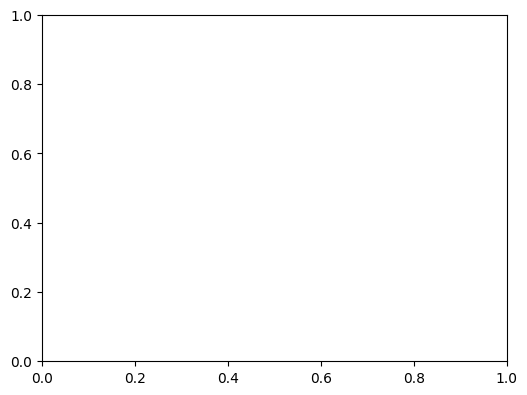

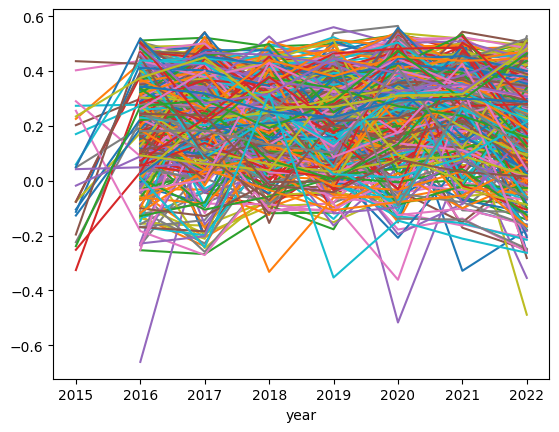

In [172]:
fig, ax = plt.subplots(figsize=(6, 4.5))

df_grouped.plot(legend=False)

In [352]:
med = df.groupby(['year', 'TICKER']).max().groupby('year')['rescaled_similarity'].median()
q1 = df.groupby(['year', 'TICKER']).max().groupby('year')['rescaled_similarity'].quantile(0.25)
q3 = df.groupby(['year', 'TICKER']).max().groupby('year')['rescaled_similarity'].quantile(0.75)
# med

In [353]:
med

year
2015    0.042153
2016    0.261384
2017    0.265938
2018    0.246931
2019    0.225940
2020    0.296642
2021    0.300197
2022    0.215541
Name: rescaled_similarity, dtype: float64

Text(0.5, 1.0, 'Similarity over time')

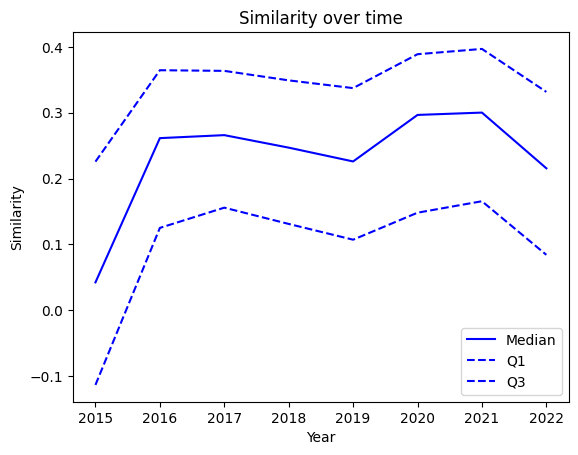

In [355]:
plt.plot(med.index, med, color='blue', label='Median')
plt.plot(q1.index, q1, color='blue', label='Q1', linestyle='dashed')
plt.plot(q3.index, q3, color='blue', label='Q3', linestyle='dashed')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Similarity')
plt.title('Similarity over time')

In [263]:
df

,company,doc_id,date,similarity,rescaled_similarity,year,rescaled_similarity_lagged
0,AAL,0000004515,2019-01-10,0.833389,-0.032357,2019,0.399284
1,AAL,0000004515,2019-01-24,0.838403,-0.012299,2019,0.399284
2,AAL,0000004515,2019-01-10,0.933081,0.366411,2019,0.399284
3,AAL,0000004515,2019-01-24,0.808383,-0.132380,2019,0.399284
4,AAL,0000006201,2019-02-12,0.874720,0.132966,2019,0.399284
...,...,...,...,...,...,...,...
16433,XRAY,0000818479,2022-02-28,0.791388,-0.200360,2022,0.491459
16434,XRAY,0000818479,2022-02-22,0.913839,0.289442,2022,0.491459
16435,XRAY,0000818479,2022-02-28,0.836279,-0.020795,2022,0.491459
16436,ZION,0000109380,2022-01-24,0.775720,-0.263032,2022,0.343987


In [33]:
items = df['company'].unique()

file = open('items.txt','w')

for item in items:
	file.write(item+"\n")

file.close()

In [34]:
df_main = pd.read_csv('data\divop.csv')  

In [35]:
df_main['spread'] = (df_main['ASKHI'] - df_main['BIDLO'])/df_main['PRC']
df_main['date'] = pd.to_datetime(df_main['date'])
df_main['year'] = df_main['date'].dt.year
df_main['month'] = df_main['date'].dt.month
df_main

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,spread,year,month
0,10104,2014-12-01,ORCL,42.01000,42.38000,42.08000,0.008793,2014,12
1,10104,2014-12-02,ORCL,41.86000,42.36000,42.18000,0.011854,2014,12
2,10104,2014-12-03,ORCL,41.63500,42.14000,42.06000,0.012007,2014,12
3,10104,2014-12-04,ORCL,41.49000,42.12000,41.89000,0.015039,2014,12
4,10104,2014-12-05,ORCL,41.59000,42.02000,41.93000,0.010255,2014,12
...,...,...,...,...,...,...,...,...,...
1007088,93096,2022-12-23,DG,244.32001,248.78000,247.55000,0.018017,2022,12
1007089,93096,2022-12-27,DG,244.64999,248.24500,247.17000,0.014545,2022,12
1007090,93096,2022-12-28,DG,244.77000,249.27499,245.00999,0.018387,2022,12
1007091,93096,2022-12-29,DG,244.99300,249.25500,248.00999,0.017185,2022,12


In [36]:
lag_change = df_main.groupby(['TICKER', 'year', 'month']).mean()['spread'].diff(periods=2)
df_main = df_main.join(lag_change, on=['TICKER', 'year', 'month'], rsuffix='_change')
df_main[df_main['month'] == 2].groupby(['year','TICKER']).mean()

PERMNO                          date       BIDLO       ASKHI   
year TICKER                                                                  
2015 A       87432.0 2015-02-14 10:06:18.947368448   40.111189   40.766053  \
     AA      24643.0 2015-02-14 10:06:18.947368448   15.614184   16.012263   
     AAL     21020.0 2015-02-14 10:06:18.947368448   47.954421   49.637579   
     AAP     89217.0 2015-02-14 10:06:18.947368448  154.623422  157.661717   
     AAPL    14593.0 2015-02-14 10:06:18.947368448  124.031000  126.144738   
...              ...                           ...         ...         ...   
2022 XYL     13035.0 2022-02-13 12:37:53.684210432   90.457368   93.449137   
     YUM     85348.0 2022-02-13 12:37:53.684210432  122.686895  125.502105   
     ZBH     89070.0 2022-02-13 12:37:53.684210432  118.938195  122.595526   
     ZION    84129.0 2022-02-13 12:37:53.684210432   70.116174   72.415579   
     ZTS     13788.0 2022-02-13 12:37:53.684210432  194.340922  198.711053   

                    PRC    spread  month  spread_change  
year TICKER                                              
2015 A        40.537895  0.016200    2.0      -0.003025  
     AA       15.829474  0.025161    2.0      -0.001111  
     AAL      48.895000  0.034418    2.0      -0.001987  
     AAP     156.378946  0.019478    2.0       0.001640  
     AAPL    125.431315  0.016791    2.0      -0.007023  
...                 ...       ...    ...            ...  
2022 XYL      91.868947  0.032696    2.0       0.013606  
     YUM     123.879474  0.022697    2.0       0.005814  
     ZBH     121.153684  0.030408    2.0       0.004427  
     ZION     71.383684  0.032275    2.0       0.005711  
     ZTS     196.515263  0.022270    2.0       0.004579  

[3940 rows x 8 columns]

In [37]:
df.rename(columns={'company': 'TICKER'}, inplace=True)
df

,TICKER,year,doc_id,date,similarity,rescaled_similarity,rescaled_similarity_lagged,num_disc
0,AAL,2015,0000006201,2015-12-28,0.897889,0.225644,0.429436,3
1,AIG,2015,0000005272,2015-12-31,0.813058,-0.113681,0.426742,1
2,APH,2015,0000820313,2015-12-31,0.822481,-0.075988,0.382143,1
3,BBT,2015,0000092230,2015-12-31,0.785410,-0.224272,0.219174,1
4,BK,2015,0001390777,2015-12-31,0.892145,0.202668,0.298862,2
...,...,...,...,...,...,...,...,...
3292,XYL,2022,0001524472,2022-01-28,0.845406,0.015713,0.261434,2
3293,YUM,2022,0001041061,2022-02-09,0.825447,-0.064126,0.234559,2
3294,ZBH,2022,0001136869,2022-03-01,0.962009,0.482125,0.011076,8
3295,ZION,2022,0000109380,2022-01-24,0.775720,-0.263032,0.343987,2


In [38]:
df_main = df_main.merge(df, on=['TICKER', 'year'], how='left')

In [39]:
df_main.dropna(inplace=True)
df_main

,PERMNO,date_x,TICKER,BIDLO,ASKHI,PRC,spread,year,month,spread_change,doc_id,date_y,similarity,rescaled_similarity,rescaled_similarity_lagged,num_disc
777,10104,2018-01-02,ORCL,46.170,47.8011,46.63,0.034980,2018,1,0.003887,0001341439,2018-02-01,0.861650,0.080689,0.071928,1.0
778,10104,2018-01-03,ORCL,47.440,48.0700,47.71,0.013205,2018,1,0.003887,0001341439,2018-02-01,0.861650,0.080689,0.071928,1.0
779,10104,2018-01-04,ORCL,47.715,48.1900,48.18,0.009859,2018,1,0.003887,0001341439,2018-02-01,0.861650,0.080689,0.071928,1.0
780,10104,2018-01-05,ORCL,48.280,48.6300,48.47,0.007221,2018,1,0.003887,0001341439,2018-02-01,0.861650,0.080689,0.071928,1.0
781,10104,2018-01-08,ORCL,47.940,49.0700,48.98,0.023071,2018,1,0.003887,0001341439,2018-02-01,0.861650,0.080689,0.071928,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006080,93096,2018-12-24,DG,98.080,100.8900,98.85,0.028427,2018,12,0.009239,0000029534,2018-02-12,0.904651,0.252693,0.049808,2.0
1006081,93096,2018-12-26,DG,99.954,105.9800,105.95,0.056876,2018,12,0.009239,0000029534,2018-02-12,0.904651,0.252693,0.049808,2.0
1006082,93096,2018-12-27,DG,102.870,106.9300,106.46,0.038136,2018,12,0.009239,0000029534,2018-02-12,0.904651,0.252693,0.049808,2.0
1006083,93096,2018-12-28,DG,106.180,108.5900,107.07,0.022509,2018,12,0.009239,0000029534,2018-02-12,0.904651,0.252693,0.049808,2.0


In [40]:
df_main.reset_index(inplace=True)

In [41]:
df_main.groupby(['year', 'TICKER']).mean()

index   PERMNO                        date_x       BIDLO   
year TICKER                                                                
2015 AAL     198963.5  21020.0 2015-07-03 06:45:42.857142784   44.447715  \
     AIG     561507.5  66800.0 2015-07-03 06:45:42.857142784   58.263908   
     APH     771934.5  84769.0 2015-07-03 06:45:42.857142784   54.661394   
     BBT     583780.5  71563.0 2015-07-03 06:45:42.857142784   38.036698   
     BK      426133.5  49656.0 2015-07-03 06:45:42.857142784   40.957480   
...               ...      ...                           ...         ...   
2022 XRX     307431.0  27983.0 2022-07-02 15:23:39.920318720   17.154226   
     XYL      68938.0  13035.0 2022-07-02 15:23:39.920318720   92.277360   
     YUM     787949.0  85348.0 2022-07-02 15:23:39.920318720  117.959818   
     ZBH     887578.0  89070.0 2022-07-02 15:23:39.920318720  115.251463   
     ZION    765068.0  84129.0 2022-07-02 15:23:39.920318720   56.554200   

                  ASKHI         PRC    spread     month  spread_change doc_id   
year TICKER                                                                     
2015 AAL      45.835482   45.121607  0.030970  6.567460      -0.001088    inf  \
     AIG      59.201569   58.761627  0.016049  6.567460       0.000174    inf   
     APH      55.568154   55.133889  0.016620  6.567460      -0.000140    inf   
     BBT      38.674767   38.365952  0.016747  6.567460      -0.005708    inf   
     BK       41.634876   41.307183  0.016558  6.567460      -0.000208    inf   
...                 ...         ...       ...       ...            ...    ...   
2022 XRX      17.783241   17.483566  0.036635  6.549801       0.001143    inf   
     XYL      94.743889   93.544382  0.026630  6.549801       0.000147    inf   
     YUM     120.405382  119.155896  0.020631  6.549801       0.000060    inf   
     ZBH     118.113706  116.746574  0.024588  6.549801      -0.001115    inf   
     ZION     58.325313   57.436733  0.030660  6.549801       0.000481    inf   

                date_y  similarity  rescaled_similarity   
year TICKER                                               
2015 AAL    2015-12-28    0.897889             0.225644  \
     AIG    2015-12-31    0.813058            -0.113681   
     APH    2015-12-31    0.822481            -0.075988   
     BBT    2015-12-31    0.785410            -0.224272   
     BK     2015-12-31    0.892145             0.202668   
...                ...         ...                  ...   
2022 XRX    2022-02-23    0.961598             0.480479   
     XYL    2022-01-28    0.845406             0.015713   
     YUM    2022-02-09    0.825447            -0.064126   
     ZBH    2022-03-01    0.962009             0.482125   
     ZION   2022-01-24    0.775720            -0.263032   

             rescaled_similarity_lagged  num_disc  
year TICKER                                        
2015 AAL                       0.429436       3.0  
     AIG                       0.426742       1.0  
     APH                       0.382143       1.0  
     BBT                       0.219174       1.0  
     BK                        0.298862       2.0  
...                                 ...       ...  
2022 XRX                       0.244374       6.0  
     XYL                       0.261434       2.0  
     YUM                       0.234559       2.0  
     ZBH                       0.011076       8.0  
     ZION                      0.343987       2.0  

[3213 rows x 15 columns]

In [42]:
df_main.to_pickle("./reg_df2.pkl")  

In [375]:
from colour import Color

purple = Color("purple")
colors = list(purple.range_to(Color("blue"),8))

Text(0.5, 1.0, '2022 Similarity vs Spread Change')

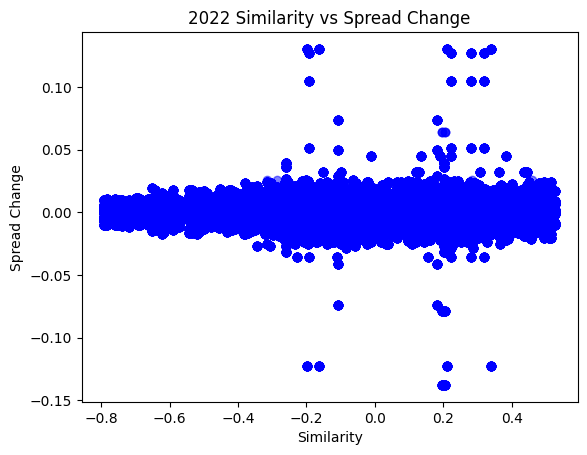

In [379]:
df_sccatter = df_main[df_main['year'] == 2022]

plt.scatter(df_sccatter['rescaled_similarity'], df_sccatter['spread_change'], color='blue', alpha=0.5)
plt.xlabel('Similarity')
plt.ylabel('Spread Change')
plt.title('2022 Similarity vs Spread Change')